<a href="https://colab.research.google.com/github/santoshgurujula/ML_TF/blob/master/TimeSeriesModel_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# First, import the relevant modules
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
plt.rcParams['figure.figsize'] = 10,6

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import tensorflow as tf 
tf.test.gpu_device_name() 

''

In [3]:
#pointing the path to google drive folder
%cd '/content/drive/My Drive/Springboard/data'
!ls

/content/drive/My Drive/Springboard/data
BOM500002.csv  BOM500013.csv  fig2.png
BOM500003.csv  BOM500014.csv  FinalStockData.csv
BOM500008.csv  BOM500020.csv  interpolating-timeseries-p1-pandas-fig1.png
BOM500009.csv  BOM500023.csv  nasdl.csv
BOM500010.csv  DJI.csv
BOM500012.csv  fig1.png


In [4]:
dataset = pd.read_csv('/content/drive/My Drive/Springboard/data/FinalStockData.csv')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 862 entries, 0 to 861
Columns: 133 entries, Unnamed: 0 to Adj Close
dtypes: float64(131), int64(1), object(1)
memory usage: 895.8+ KB


In [5]:
dataset.head()

,Unnamed: 0,Date,Open_BOM500002,Open_BOM500003,Open_BOM500008,Open_BOM500009,Open_BOM500010,Open_BOM500012,Open_BOM500013,Open_BOM500014,Open_BOM500020,Open_BOM500023,High_BOM500002,High_BOM500003,High_BOM500008,High_BOM500009,High_BOM500010,High_BOM500012,High_BOM500013,High_BOM500014,High_BOM500020,High_BOM500023,Low_BOM500002,Low_BOM500003,Low_BOM500008,Low_BOM500009,Low_BOM500010,Low_BOM500012,Low_BOM500013,Low_BOM500014,Low_BOM500020,Low_BOM500023,Close_BOM500002,Close_BOM500003,Close_BOM500008,Close_BOM500009,Close_BOM500010,Close_BOM500012,Close_BOM500013,Close_BOM500014,...,% Deli. Qty to Traded Qty_BOM500003,% Deli. Qty to Traded Qty_BOM500008,% Deli. Qty to Traded Qty_BOM500009,% Deli. Qty to Traded Qty_BOM500010,% Deli. Qty to Traded Qty_BOM500012,% Deli. Qty to Traded Qty_BOM500013,% Deli. Qty to Traded Qty_BOM500014,% Deli. Qty to Traded Qty_BOM500020,% Deli. Qty to Traded Qty_BOM500023,Spread H-L_BOM500002,Spread H-L_BOM500003,Spread H-L_BOM500008,Spread H-L_BOM500009,Spread H-L_BOM500010,Spread H-L_BOM500012,Spread H-L_BOM500013,Spread H-L_BOM500014,Spread H-L_BOM500020,Spread H-L_BOM500023,Spread C-O_BOM500002,Spread C-O_BOM500003,Spread C-O_BOM500008,Spread C-O_BOM500009,Spread C-O_BOM500010,Spread C-O_BOM500012,Spread C-O_BOM500013,Spread C-O_BOM500014,Spread C-O_BOM500020,Spread C-O_BOM500023,Gross_Purchases,Gross_Sales,Net_Investment_INR,Net_Investment_USD,Conversion_Rate,High,Low,Open,Close,Volume,Adj Close
0,0,2017-01-02,1045.0,129.00,870.05,7.00,1275.00,21.9,15.50,2.50,49.05,NaN,1052.0,132.45,898.95,7.89,1275.0,22.00,16.08,2.50,49.90,NaN,1035.00,129.00,867.6,7.00,1214.15,21.50,14.86,2.30,48.35,NaN,1039.95,131.05,896.20,7.09,1219.25,21.60,15.30,2.37,...,59.65,12.15,87.01,21.24,77.39,38.58,82.68,27.28,NaN,17.00,3.45,31.35,0.89,60.85,0.50,1.22,0.20,1.55,NaN,-5.05,2.05,26.15,0.09,-55.75,-0.30,-0.20,-0.13,-0.25,NaN,2230.64,2796.67,-566.03,-83.29,67.9547,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2017-01-03,1069.9,132.30,900.00,7.04,1220.00,21.9,15.50,2.47,49.00,106.950000,1069.9,135.00,900.00,7.30,1222.0,21.90,15.70,2.48,49.80,106.950000,1037.90,132.00,882.9,7.04,1201.00,21.10,15.10,2.32,48.55,106.950000,1045.05,132.50,890.20,7.25,1215.25,21.70,15.32,2.43,...,37.15,24.99,89.13,54.61,89.96,64.98,80.71,44.10,100.000000,32.00,3.00,17.10,0.26,21.00,0.80,0.60,0.16,1.25,0.000000,-24.85,0.20,-9.80,0.21,-4.75,-0.20,-0.18,-0.04,-0.20,0.000000,867.26,1185.97,-318.71,-46.85,68.0225,19938.529297,19775.929688,19872.859375,19881.759766,339180000.0,19881.759766
2,2,2017-01-04,1050.0,134.15,892.00,7.13,1215.25,22.5,15.32,2.48,50.25,104.050000,1050.0,134.60,909.25,7.40,1225.0,22.75,15.44,2.50,51.90,104.050000,1033.50,131.25,890.0,7.11,1197.55,21.25,15.12,2.35,50.25,104.025000,1037.35,131.75,898.50,7.26,1212.50,22.75,15.28,2.47,...,61.49,24.11,83.89,92.28,74.31,84.28,96.69,31.95,100.000000,16.50,3.35,19.25,0.29,27.45,1.50,0.32,0.15,1.65,0.025000,-12.65,-2.40,6.50,0.13,-2.75,0.25,-0.04,-0.01,0.65,-0.025000,1863.97,2400.72,-536.75,-78.84,68.0864,19956.140625,19878.830078,19890.939453,19942.160156,280010000.0,19942.160156
3,3,2017-01-05,1051.9,132.00,905.00,7.02,1225.00,23.7,15.43,2.34,51.25,101.150000,1051.9,133.25,935.25,7.50,1225.0,23.85,15.52,2.49,54.40,101.150000,1029.55,130.00,900.0,7.02,1205.30,22.90,15.26,2.33,51.20,101.100000,1031.45,131.65,916.35,7.34,1216.55,23.85,15.48,2.41,...,59.06,27.79,72.79,23.37,73.78,76.37,69.64,32.58,100.000000,22.35,3.25,35.25,0.48,19.70,0.95,0.26,0.16,3.20,0.050000,-20.45,-0.35,11.35,0.32,-8.45,0.15,0.05,0.07,2.60,-0.050000,3534.18,4226.17,-691.99,-101.50,68.1791,19948.599609,19811.119141,19924.560547,19899.289062,269920000.0,19899.289062
4,4,2017-01-06,1037.0,132.90,916.35,7.35,1216.55,24.9,15.26,2.36,54.20,101.166667,1048.0,133.00,932.15,7.55,1232.4,25.00,15.45,2.45,54.35,101.766667,1035.55,129.55,915.0,7.21,1216.55,23.00,15.01,2.35,52.75,101.133333,1043.90,130.10,928.05,7.40,1222.15,24.95,15.11,2.45,...,49.28,12.28,85.11,82.03,70.79,73.11,87.23,38.97,83.333333,12.45,3.45,17.15,0.34,15.85,2.00,0.44,0.10,

In [6]:
print(dataset.columns)

Index(['Unnamed: 0', 'Date', 'Open_BOM500002', 'Open_BOM500003',
       'Open_BOM500008', 'Open_BOM500009', 'Open_BOM500010', 'Open_BOM500012',
       'Open_BOM500013', 'Open_BOM500014',
       ...
       'Gross_Sales', 'Net_Investment_INR', 'Net_Investment_USD',
       'Conversion_Rate', 'High', 'Low', 'Open', 'Close', 'Volume',
       'Adj Close'],
      dtype='object', length=133)


In [7]:
#select only 1 stock Open and close, Conversion_rate , Dowjones Open and close columns
features= ['Date','Open_BOM500002','Close_BOM500002', 'Conversion_Rate','Open','Close']
sub_dataset=dataset[features]

In [8]:
#Rename DJI Open and CLose
sub_dataset=sub_dataset.rename(columns={"Open": "DJIOpen", "Close": "DJIClose"})

In [9]:
sub_dataset.head()

,Date,Open_BOM500002,Close_BOM500002,Conversion_Rate,DJIOpen,DJIClose
0,2017-01-02,1045.0,1039.95,67.9547,NaN,NaN
1,2017-01-03,1069.9,1045.05,68.0225,19872.859375,19881.759766
2,2017-01-04,1050.0,1037.35,68.0864,19890.939453,19942.160156
3,2017-01-05,1051.9,1031.45,68.1791,19924.560547,19899.289062
4,2017-01-06,1037.0,1043.90,67.7884,19906.960938,19963.800781


In [10]:
sub_dataset.sort_values(by='Date')

,Date,Open_BOM500002,Close_BOM500002,Conversion_Rate,DJIOpen,DJIClose
0,2017-01-02,1045.00,1039.95,67.9547,NaN,NaN
1,2017-01-03,1069.90,1045.05,68.0225,19872.859375,19881.759766
2,2017-01-04,1050.00,1037.35,68.0864,19890.939453,19942.160156
3,2017-01-05,1051.90,1031.45,68.1791,19924.560547,19899.289062
4,2017-01-06,1037.00,1043.90,67.7884,19906.960938,19963.800781
...,...,...,...,...,...,...
857,2020-06-24,854.65,866.50,75.7549,25992.960938,25445.939453
858,2020-06-25,870.00,887.50,75.7087,25365.220703,25745.599609
859,2020-06-26,888.00,913.60,75.6349,25641.689453,25015.550781
860,2020-06-29,915.00,919.90,75.4757,25152.449219,25595.800781


In [11]:
#parse string to datetime
sub_dataset['Date']=pd.to_datetime(sub_dataset['Date'],infer_datetime_format=True)


In [12]:
sub_dataset['Date'].min()

Timestamp('2017-01-02 00:00:00')

In [13]:
index_range=pd.date_range(start=sub_dataset['Date'].min(), end=sub_dataset['Date'].max(), freq='B')

In [14]:
IndexedDataset=sub_dataset.set_index(['Date'])

In [15]:
IndexedDataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 862 entries, 2017-01-02 to 2020-06-30
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open_BOM500002   862 non-null    float64
 1   Close_BOM500002  862 non-null    float64
 2   Conversion_Rate  862 non-null    float64
 3   DJIOpen          861 non-null    float64
 4   DJIClose         861 non-null    float64
dtypes: float64(5)
memory usage: 40.4 KB


In [16]:
IndexedDataset.head()

,Open_BOM500002,Close_BOM500002,Conversion_Rate,DJIOpen,DJIClose
Date,,,,,
2017-01-02,1045.0,1039.95,67.9547,NaN,NaN
2017-01-03,1069.9,1045.05,68.0225,19872.859375,19881.759766
2017-01-04,1050.0,1037.35,68.0864,19890.939453,19942.160156
2017-01-05,1051.9,1031.45,68.1791,19924.560547,19899.289062
2017-01-06,1037.0,1043.90,67.7884,19906.960938,19963.800781


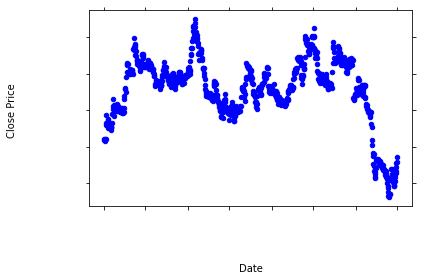

In [17]:
#plot Graph
#Plot stock Close price  against Date 
plt.scatter(IndexedDataset.index,
               IndexedDataset['Close_BOM500002'],
               color='blue',
               s=20)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)

plt.xlabel('Date', labelpad=40)
plt.ylabel('Close Price ', labelpad=40)

plt.tight_layout()
plt.savefig('fig1.png')
plt.show()
plt.close()

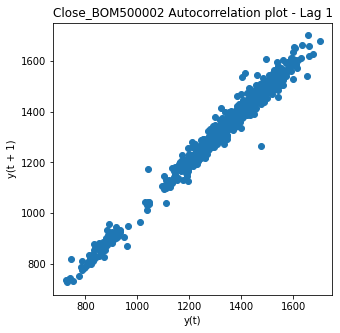

In [18]:
#plot the Autocorrelation plot for feature 'Close'
from pandas.plotting import lag_plot

plt.figure(figsize=(5,5))
lag_plot(IndexedDataset['Close_BOM500002'], lag=1)
plt.title('Close_BOM500002 Autocorrelation plot - Lag 1');
# END_CODE_HERE

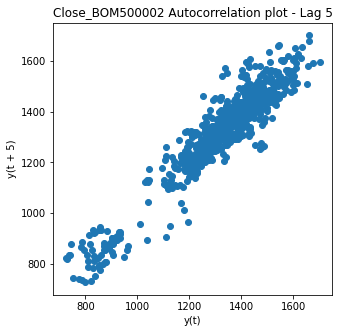

In [19]:
#  plot the Autocorrelation plot for feature 'Close' with Lag5

plt.figure(figsize=(5,5))
lag_plot(IndexedDataset['Close_BOM500002'], lag=5)
plt.title('Close_BOM500002 Autocorrelation plot - Lag 5');


Build Train and Test Data set

In [20]:
train_data, test_data = IndexedDataset.iloc[0:int(len(IndexedDataset)*0.8), :], IndexedDataset.iloc[int(len(IndexedDataset)*0.8):, :]

In [21]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 689 entries, 2017-01-02 to 2019-10-17
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open_BOM500002   689 non-null    float64
 1   Close_BOM500002  689 non-null    float64
 2   Conversion_Rate  689 non-null    float64
 3   DJIOpen          688 non-null    float64
 4   DJIClose         688 non-null    float64
dtypes: float64(5)
memory usage: 32.3 KB


In [22]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 173 entries, 2019-10-18 to 2020-06-30
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open_BOM500002   173 non-null    float64
 1   Close_BOM500002  173 non-null    float64
 2   Conversion_Rate  173 non-null    float64
 3   DJIOpen          173 non-null    float64
 4   DJIClose         173 non-null    float64
dtypes: float64(5)
memory usage: 8.1 KB


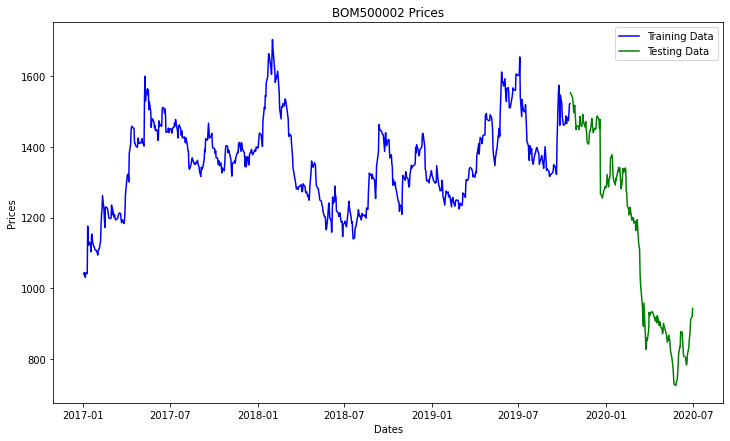

In [23]:
plt.figure(figsize=(12,7))
plt.title('BOM500002 Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_data['Close_BOM500002'], 'blue', label='Training Data')
plt.plot(test_data['Close_BOM500002'], 'green', label='Testing Data')
plt.legend();

In [24]:
#Check Rolling mean and std
rolmean = train_data.rolling(window=5).mean()
rolstd =  train_data.rolling(window=5).std()

print(rolmean,rolstd)

            Open_BOM500002  Close_BOM500002  ...       DJIOpen      DJIClose
Date                                         ...                            
2017-01-02             NaN              NaN  ...           NaN           NaN
2017-01-03             NaN              NaN  ...           NaN           NaN
2017-01-04             NaN              NaN  ...           NaN           NaN
2017-01-05             NaN              NaN  ...           NaN           NaN
2017-01-06         1050.76          1039.54  ...           NaN           NaN
...                    ...              ...  ...           ...           ...
2019-10-11         1476.28          1472.03  ...  26418.761719  26542.201953
2019-10-14         1481.40          1474.68  ...  26517.707813  26584.929688
2019-10-15         1483.19          1481.14  ...  26579.481641  26694.285938
2019-10-16         1490.35          1487.59  ...  26712.297656  26825.480078
2019-10-17         1497.15          1498.80  ...  26855.303906  26931.322266

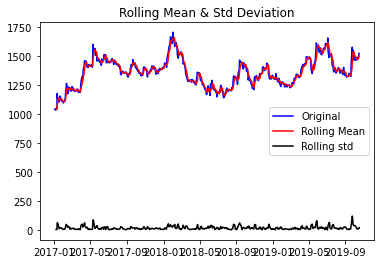

In [25]:
orig = plt.plot(train_data['Close_BOM500002'],color='blue',label='Original')
mean= plt.plot(rolmean['Close_BOM500002'],color='red',label='Rolling Mean')
std= plt.plot(rolstd['Close_BOM500002'],color='black',label='Rolling std')
plt.legend(loc='best')
plt.title('Rolling Mean & Std Deviation')
plt.show(block=False)

In [26]:
def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

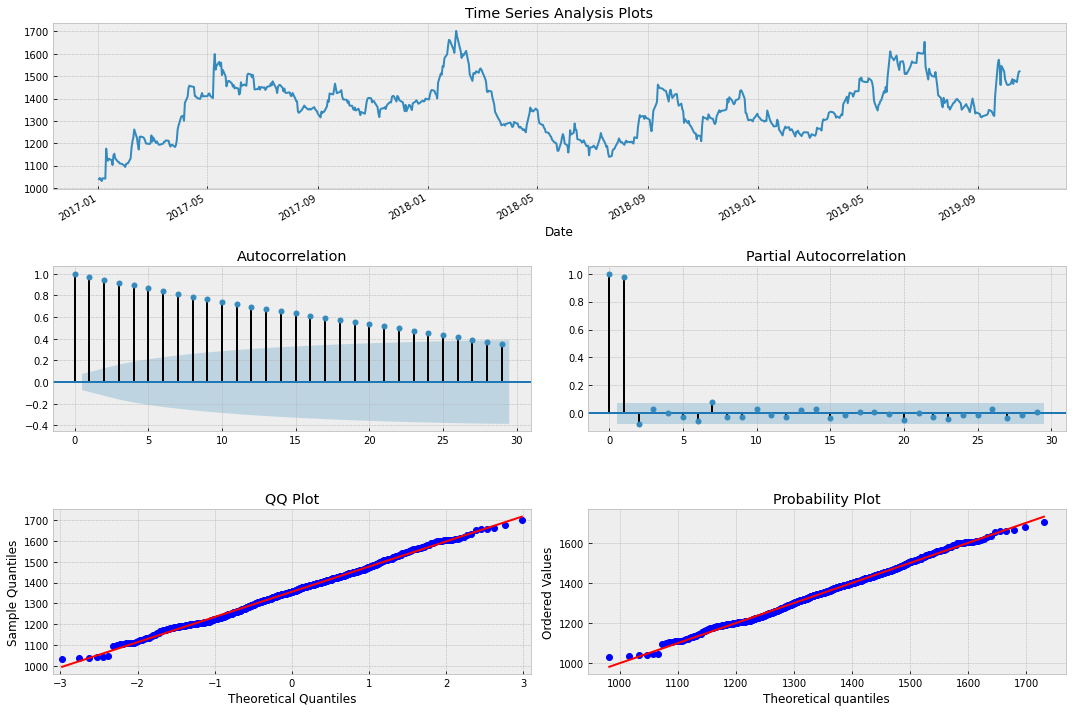

In [27]:
tsplot(train_data['Close_BOM500002'])

**We observe there is trend above ACF plot**

Below  we remove trend by using np.diff()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


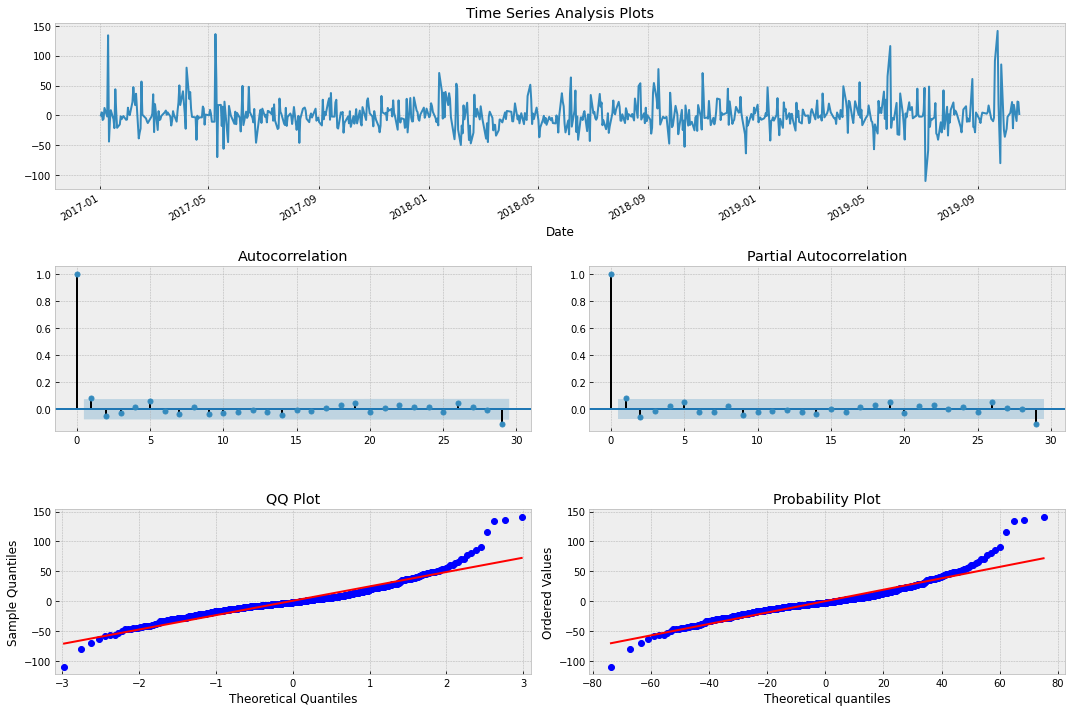

In [28]:
#use np.diff to remove trend
#train_data['Close_BOM500002_log']=np.log(train_data['Close_BOM500002'])
train_data['Close_BOM500002_diff']=np.append(0,np.diff(train_data['Close_BOM500002']))
#IndexedDataset['Close_BOM500002_logdiff']= IndexedDataset['Close_BOM500002']-IndexedDataset['Close_BOM500002'].shift() 
#IndexedDataset['Close_BOM500002_logdiff']
tsplot(train_data['Close_BOM500002_diff'])

**We observe from above plot trend is removed , but we observe correlaion at lag 9,14 .. from ACF and PACF**



In [29]:
#Check Dickey - Fuller test
from statsmodels.tsa.stattools import adfuller

print('Results of Dickey Fuller test:')
dftest=adfuller(train_data['Close_BOM500002'],autolag='AIC')

dfoutput = pd.Series(dftest[0:4],index = ['Test Statistcs ', 'p-value', '#lags used', 'No of Observations used'] )
for key,value in dftest[4].items():
  dfoutput['Critical Value (%s)'%key]=value

print(dfoutput)

Results of Dickey Fuller test:
Test Statistcs              -3.293439
p-value                      0.015174
#lags used                   1.000000
No of Observations used    687.000000
Critical Value (1%)         -3.439904
Critical Value (5%)         -2.865756
Critical Value (10%)        -2.569015
dtype: float64


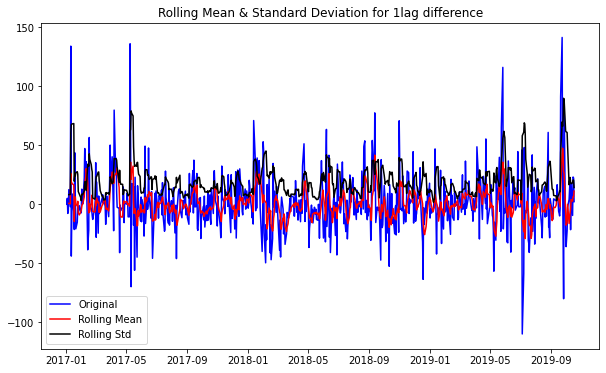

In [30]:
#Determing rolling statistics
window=5
rolmean_diff = train_data['Close_BOM500002_diff'].rolling(window).mean()
rolstd_diff = train_data['Close_BOM500002_diff'].rolling(window).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(10, 6))
orig = plt.plot(train_data['Close_BOM500002_diff'], color='blue',label='Original')
mean = plt.plot(rolmean_diff, color='red', label='Rolling Mean')
std = plt.plot(rolstd_diff, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation for 1lag difference');

In [31]:
#Check Dickey - Fuller test
from statsmodels.tsa.stattools import adfuller

print('Results of Dickey Fuller test:')
dftest=adfuller(train_data['Close_BOM500002_diff'],autolag='AIC')

dfoutput = pd.Series(dftest[0:4],index = ['Test Statistcs ', 'p-value', '#lags used', 'No of Observations used'] )
for key,value in dftest[4].items():
  dfoutput['Critical Value (%s)'%key]=value

print(dfoutput)

Results of Dickey Fuller test:
Test Statistcs            -1.880881e+01
p-value                    2.022518e-30
#lags used                 1.000000e+00
No of Observations used    6.870000e+02
Critical Value (1%)       -3.439904e+00
Critical Value (5%)       -2.865756e+00
Critical Value (10%)      -2.569015e+00
dtype: float64


After differencing, the p-value is extremely small. Thus this series is very likely to be stationary.



/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Partial Autocorrelation Function')

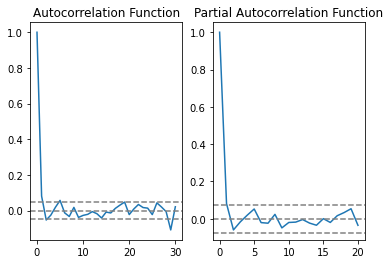

In [32]:
#plot ACF and PACF
from statsmodels.tsa.stattools import acf,pacf

lag_acf=acf(train_data['Close_BOM500002_diff'],nlags=30)
lag_pacf = pacf (train_data['Close_BOM500002_diff'],nlags=20, method ='ols')

#plot ACF
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.25/np.sqrt(len(train_data['Close_BOM500002_diff'])),linestyle='--',color='gray')
plt.axhline(y=1.25/np.sqrt(len(train_data['Close_BOM500002_diff'])),linestyle='--',color='gray')
plt.title('Autocorrelation Function')


#plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_data['Close_BOM500002_diff'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_data['Close_BOM500002_diff'])),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')


In [33]:
#creae test difference series and train difference series 
test_series = test_data['Close_BOM500002']
test_diff = test_series.diff()
test_diff = test_diff.dropna(inplace = False)

train_series = train_data['Close_BOM500002']
train_diff = train_series.diff()
train_diff = test_diff.dropna(inplace = False)

**From ACF, we can say p=1 and from PACF we can say q=1**

Now build ARIMA model using p=1,d=1 and q=1

In [34]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error



In [35]:
%%time 

history = [x for x in train_diff]
p=1
d=1
q=1
predictions = list()
for t in range(len(test_diff)):

    # START_CODE_HERE - call the ARIMA Method with history and params
    
    model = ARIMA(history,order=(p,d,q))  # initialize the model with history and right order of parameters
    model_fit = model.fit(disp=-1)  # fit the model
    # END_CODE_HERE

    output = model_fit.forecast()  # use forecast on the fitted model
    yhat = output[0][0]
    predictions.append(yhat)

    obs = test_diff[t]
    history.append(obs)

    if t % 100 == 0:
      print('Test Series Point: {}\tPredicted={}, Expected={}'.format(t, yhat, obs))

Test Series Point: 0	Predicted=0.34373524312061576, Expected=-12.600000000000136
Test Series Point: 100	Predicted=-3.5232231218155334, Expected=-26.850000000000136


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


CPU times: user 16 s, sys: 7.21 ms, total: 16 s
Wall time: 16 s


In [36]:
#reverse the foreasted values
reverse_test_diff = np.r_[test_series.iloc[0], test_diff].cumsum()
reverse_predictions = np.r_[test_series.iloc[0], predictions].cumsum()
reverse_test_diff.shape, reverse_predictions.shape

((173,), (173,))

In [37]:
error = mean_squared_error(reverse_test_diff, reverse_predictions)
print('Testing Mean Squared Error: %.3f' % error)

Testing Mean Squared Error: 71189.774


In [38]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

In [39]:
res_tup = _get_best_model(train_diff)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

aic: 1626.24338 | order: (0, 1, 1)


In [40]:
#print best model order
order=res_tup[1]
print(order)

(0, 1, 1)


In [41]:
def build_model(ts_train,ts_test,order):

  %%time 

  history = [x for x in ts_train]

  predictions = list()
  for t in range(len(ts_test)):

      # START_CODE_HERE - call the ARIMA Method with history and params
      
      model = ARIMA(history,order=order)  # initialize the model with history and right order of parameters
      model_fit = model.fit(disp=-1)  # fit the model
      # END_CODE_HERE

      output = model_fit.forecast()  # use forecast on the fitted model
      yhat = output[0][0]
      predictions.append(yhat)

      obs = ts_test[t]
      history.append(obs)

      if t % 100 == 0:
        print('Test Series Point: {}\tPredicted={}, Expected={}'.format(t, yhat, obs))
  return predictions,model_fit

In [42]:
predictions,model_fit= build_model(train_diff,test_diff,order=(1,1,1))

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 7.15 µs
Test Series Point: 0	Predicted=0.34373524312061576, Expected=-12.600000000000136
Test Series Point: 100	Predicted=-3.5232231218155334, Expected=-26.850000000000136


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [43]:
#reverse the foreasted values
reverse_test_diff = np.r_[test_series.iloc[0], test_diff].cumsum()
reverse_predictions = np.r_[test_series.iloc[0], predictions].cumsum()
reverse_test_diff.shape, reverse_predictions.shape

((173,), (173,))

In [44]:
error = mean_squared_error(reverse_test_diff, reverse_predictions)
print('Testing Mean Squared Error: %.3f' % error)

Testing Mean Squared Error: 71189.774


Visualize the forecast results


In [45]:
reverse_test_diff_series = pd.Series(reverse_test_diff)
reverse_test_diff_series.index = test_series.index

reverse_predictions_series = pd.Series(reverse_predictions)
reverse_predictions_series.index = test_series.index

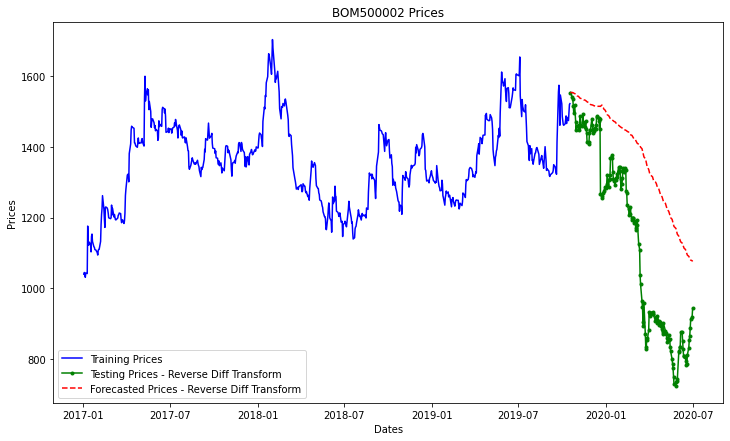

In [46]:
plt.figure(figsize=(12,7))
plt.title('BOM500002 Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_series, color='blue', label='Training Prices')
plt.plot(reverse_test_diff_series, color='green', marker='.', label='Testing Prices - Reverse Diff Transform')
plt.plot(reverse_predictions_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Diff Transform')
plt.legend();

Visualize only test and forecast prices


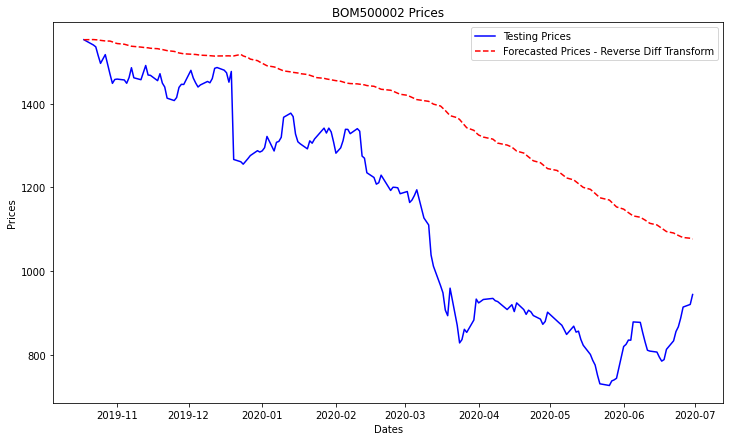

In [47]:
plt.figure(figsize=(12,7))
plt.title('BOM500002 Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(test_series, color='blue', label='Testing Prices')
#plt.plot(reverse_test_diff_series, color='green', marker='.', label='Testing Prices - Reverse Diff Transform')
plt.plot(reverse_predictions_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Diff Transform')
plt.legend();

**Multivariate Model**

In [48]:
#Create a list containing Open and Close columns of Stocks
multi_features=[ i for i in dataset.columns.to_list() if 'Close_BOM' in i]
print(multi_features)

['Close_BOM500002', 'Close_BOM500003', 'Close_BOM500008', 'Close_BOM500009', 'Close_BOM500010', 'Close_BOM500012', 'Close_BOM500013', 'Close_BOM500014', 'Close_BOM500020', 'Close_BOM500023']


In [49]:
#add Conversion_rate and Dowjones  close columns to features list
multi_features.extend(
           ['Date','Conversion_Rate','Close'])
print(multi_features)


['Close_BOM500002', 'Close_BOM500003', 'Close_BOM500008', 'Close_BOM500009', 'Close_BOM500010', 'Close_BOM500012', 'Close_BOM500013', 'Close_BOM500014', 'Close_BOM500020', 'Close_BOM500023', 'Date', 'Conversion_Rate', 'Close']


In [50]:
#Create subset data with the features listed above
multi_subset_df=dataset[multi_features]

In [51]:
#Rename DJI Open and CLose
multi_subset_df=multi_subset_df.rename(columns={ "Close": "DJIClose"})

In [52]:
#parse string to datetime
multi_subset_df['Date']=pd.to_datetime(multi_subset_df['Date'],infer_datetime_format=True)

In [53]:
#Set Date as index
multi_subset_df=multi_subset_df.set_index(['Date'])

In [54]:
multi_subset_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 862 entries, 2017-01-02 to 2020-06-30
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Close_BOM500002  862 non-null    float64
 1   Close_BOM500003  862 non-null    float64
 2   Close_BOM500008  862 non-null    float64
 3   Close_BOM500009  862 non-null    float64
 4   Close_BOM500010  862 non-null    float64
 5   Close_BOM500012  862 non-null    float64
 6   Close_BOM500013  862 non-null    float64
 7   Close_BOM500014  862 non-null    float64
 8   Close_BOM500020  862 non-null    float64
 9   Close_BOM500023  861 non-null    float64
 10  Conversion_Rate  862 non-null    float64
 11  DJIClose         861 non-null    float64
dtypes: float64(12)
memory usage: 87.5 KB


In [55]:
multi_subset_df.head()

,Close_BOM500002,Close_BOM500003,Close_BOM500008,Close_BOM500009,Close_BOM500010,Close_BOM500012,Close_BOM500013,Close_BOM500014,Close_BOM500020,Close_BOM500023,Conversion_Rate,DJIClose
Date,,,,,,,,,,,,
2017-01-02,1039.95,131.05,896.20,7.09,1219.25,21.60,15.30,2.37,48.80,NaN,67.9547,NaN
2017-01-03,1045.05,132.50,890.20,7.25,1215.25,21.70,15.32,2.43,48.80,106.950000,68.0225,19881.759766
2017-01-04,1037.35,131.75,898.50,7.26,1212.50,22.75,15.28,2.47,50.90,104.025000,68.0864,19942.160156
2017-01-05,1031.45,131.65,916.35,7.34,1216.55,23.85,15.48,2.41,53.85,101.100000,68.1791,19899.289062
2017-01-06,1043.90,130.10,928.05,7.40,1222.15,24.95,15.11,2.45,53.30,101.733333,67.7884,19963.800781


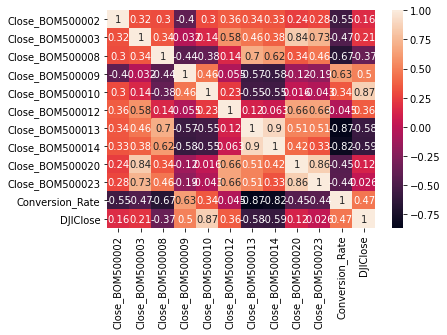

In [56]:
import seaborn as sn
corrMatrix=multi_subset_df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()


In [57]:
multi_subset_df.dropna(inplace=True)

In [58]:
#Exclude BOM500002 close price , which we want to predict
ARIMA_Features=[i for i in  multi_subset_df.columns.to_list() if i !='Close_BOM500002']
print(ARIMA_Features)

['Close_BOM500003', 'Close_BOM500008', 'Close_BOM500009', 'Close_BOM500010', 'Close_BOM500012', 'Close_BOM500013', 'Close_BOM500014', 'Close_BOM500020', 'Close_BOM500023', 'Conversion_Rate', 'DJIClose']


In [59]:
multi_set_model=ARIMA(endog=multi_subset_df['Close_BOM500002'],exog=multi_subset_df[ARIMA_Features],order=(0,1,1))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [60]:
multi_set_result=multi_set_model.fit(disp=-1)

In [61]:
#Split df to train and test data
multi_train_data, multi_test_data = multi_subset_df.iloc[0:int(len(multi_subset_df)*0.8), :], multi_subset_df.iloc[int(len(multi_subset_df)*0.8):, :]

In [62]:
multi_train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 688 entries, 2017-01-03 to 2019-10-17
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Close_BOM500002  688 non-null    float64
 1   Close_BOM500003  688 non-null    float64
 2   Close_BOM500008  688 non-null    float64
 3   Close_BOM500009  688 non-null    float64
 4   Close_BOM500010  688 non-null    float64
 5   Close_BOM500012  688 non-null    float64
 6   Close_BOM500013  688 non-null    float64
 7   Close_BOM500014  688 non-null    float64
 8   Close_BOM500020  688 non-null    float64
 9   Close_BOM500023  688 non-null    float64
 10  Conversion_Rate  688 non-null    float64
 11  DJIClose         688 non-null    float64
dtypes: float64(12)
memory usage: 69.9 KB


In [63]:
multi_train_data.head()

,Close_BOM500002,Close_BOM500003,Close_BOM500008,Close_BOM500009,Close_BOM500010,Close_BOM500012,Close_BOM500013,Close_BOM500014,Close_BOM500020,Close_BOM500023,Conversion_Rate,DJIClose
Date,,,,,,,,,,,,
2017-01-03,1045.05,132.50,890.20,7.25,1215.25,21.70,15.32,2.43,48.80,106.950000,68.0225,19881.759766
2017-01-04,1037.35,131.75,898.50,7.26,1212.50,22.75,15.28,2.47,50.90,104.025000,68.0864,19942.160156
2017-01-05,1031.45,131.65,916.35,7.34,1216.55,23.85,15.48,2.41,53.85,101.100000,68.1791,19899.289062
2017-01-06,1043.90,130.10,928.05,7.40,1222.15,24.95,15.11,2.45,53.30,101.733333,67.7884,19963.800781
2017-01-09,1041.95,131.65,903.30,8.88,1222.25,25.10,15.40,2.68,54.20,102.366667,67.9522,19887.380859


In [64]:
#Remove trend using diff()
multi_train_data_diff=multi_train_data.diff()
multi_train_data_diff.head()

,Close_BOM500002,Close_BOM500003,Close_BOM500008,Close_BOM500009,Close_BOM500010,Close_BOM500012,Close_BOM500013,Close_BOM500014,Close_BOM500020,Close_BOM500023,Conversion_Rate,DJIClose
Date,,,,,,,,,,,,
2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,-7.70,-0.75,8.30,0.01,-2.75,1.05,-0.04,0.04,2.10,-2.925000,0.0639,60.400391
2017-01-05,-5.90,-0.10,17.85,0.08,4.05,1.10,0.20,-0.06,2.95,-2.925000,0.0927,-42.871094
2017-01-06,12.45,-1.55,11.70,0.06,5.60,1.10,-0.37,0.04,-0.55,0.633333,-0.3907,64.511719
2017-01-09,-1.95,1.55,-24.75,1.48,0.10,0.15,0.29,0.23,0.90,0.633333,0.1638,-76.419922


In [65]:
#Remove trend in test data as well using diff()
multi_test_data_diff=multi_test_data.diff()
multi_test_data_diff.head()

,Close_BOM500002,Close_BOM500003,Close_BOM500008,Close_BOM500009,Close_BOM500010,Close_BOM500012,Close_BOM500013,Close_BOM500014,Close_BOM500020,Close_BOM500023,Conversion_Rate,DJIClose
Date,,,,,,,,,,,,
2019-10-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-22,-12.60,10.65,8.10,0.08,20.60,0.30,0.00,-0.06,1.45,-6.900000,-0.2099,17.900391
2019-10-23,-4.45,-4.00,-13.65,0.44,28.55,-0.45,0.06,0.07,0.30,0.150000,-0.3257,45.849609
2019-10-24,-20.70,-6.10,-6.65,0.34,1.50,0.05,-0.11,0.00,-0.55,1.050000,0.0642,-28.419922
2019-10-25,-18.80,-5.75,-4.20,-0.21,-43.10,0.15,-0.13,0.08,-0.90,1.266667,-0.0035,152.531250


In [66]:
#Drop NaN rows
multi_train_data_diff=multi_train_data_diff.dropna(inplace = False)
multi_test_data_diff=multi_test_data_diff.dropna(inplace = False)

In [67]:
import sys
def _get_best_multi_model(TS,Y_column,X_column):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(2) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(endog=TS[Y_column],exog=TS[X_column], order=(i,d,j)).fit(
                        method='mle', trend='c',disp=-1,start_ar_lags=max(i,j)
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: print("Unexpected error:", sys.exc_info()) 
                continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

In [68]:
Y='Close_BOM500002'
res_multi_tup = _get_best_multi_model(multi_train_data_diff,Y_column=Y,X_column=ARIMA_Features)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

aic: 6265.67973 | order: (0, 0, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [69]:
#print best model order
multi_order=res_multi_tup[1]
print(multi_order)

(0, 0, 0)


**Using ARIMA model, we got COnvergence Warning**

Below we will try with SARIMAX

In [70]:
import sys
def _get_best_multi_model(TS,Y_column,X_column):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.SARIMAX(endog=TS[Y_column],exog=TS[X_column], order=(i,d,j)).fit(
                        trend='c',disp=False
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: print("Unexpected error:", sys.exc_info()) 
                continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

In [71]:
Y='Close_BOM500002'
res_multi_tup = _get_best_multi_model(multi_train_data_diff,Y_column=Y,X_column=ARIMA_Features)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWa

aic: 6264.04783 | order: (0, 0, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [72]:
#print best model order
multi_order=res_multi_tup[1]
print(multi_order)
print('aic:',res_multi_tup[0])

(0, 0, 0)
aic: 6264.047829314553


In [73]:
 tmp_mdl = smt.SARIMAX(endog=multi_train_data_diff[Y],exog=multi_train_data_diff[ARIMA_Features], order=(1,1,1)).fit(
                        trend='c',disp=False
                    )
 tmp_mdl.model.data.orig_endog.index

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


DatetimeIndex(['2017-01-04', '2017-01-05', '2017-01-06', '2017-01-09',
               '2017-01-10', '2017-01-11', '2017-01-12', '2017-01-13',
               '2017-01-16', '2017-01-17',
               ...
               '2019-10-03', '2019-10-04', '2019-10-07', '2019-10-09',
               '2019-10-10', '2019-10-11', '2019-10-14', '2019-10-15',
               '2019-10-16', '2019-10-17'],
              dtype='datetime64[ns]', name='Date', length=687, freq=None)

In [74]:
endog=multi_test_data_diff.iloc[0:0+1][Y]
start = tmp_mdl.nobs
end = tmp_mdl.nobs + len(endog) - 1
_, _, _, append_ix = tmp_mdl.model._get_prediction_index(start, end)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [75]:
print(append_ix)

RangeIndex(start=687, stop=688, step=1)


In [76]:
print(type(multi_train_data_diff.iloc[0:0+1][ARIMA_Features]))
print(pd.DataFrame(multi_test_data_diff.iloc[0:0+1][Y]).set_index(pd.Index([688])))

<class 'pandas.core.frame.DataFrame'>
     Close_BOM500002
688            -12.6


In [77]:
def build_multi_model(ts_train,ts_test,order,X_Column,Y_Column,Y_POS):

  %%time 

  history =  ts_train
  #print(Y)
  train_obs=ts_train.shape[0]
  print('training observations:',train_obs)
  updated_endog_index=train_obs
  predictions = list()
  no_of_rows =ts_test.shape[0]
      
  for t in range(0,no_of_rows):
       # START_CODE_HERE - call the ARIMA Method with history and params      
      model = smt.SARIMAX(endog=history[Y_Column],exog=history[X_Column],order=order)  # initialize the model with history and right order of parameters
      model_fit = model.fit(disp=False)  # fit the model
    
      # Update the results by appending the next observation
      #updated_endog_index +=1
      #updated_endog = pd.DataFrame(ts_test.iloc[t:t+1][Y_Column]).set_index(pd.Index([updated_endog_index]))
      #updated_exog =pd.DataFrame(ts_test.iloc[t:t+1][X_Column]).set_index(pd.Index([updated_endog_index]))
      #model_fit=model_fit.append(endog=updated_endog,refit=False )
      output = model_fit.forecast(exog=ts_test.iloc[t:t+1][X_Column],steps=1)  # use forecast on the fitted model
      #print('out:',output.iloc[-1])
      yhat = output.iloc[-1]
      predictions.append(yhat)
      obs = ts_test.iloc[t][X_Column]
      history.append(obs)
      #exog=history.iloc[train_obs+t-1:train_obs+t][X_Column]

      if t % 100 == 0:
        print('Test Series Point: {}\tPredicted={}, Expected={}'.format(t, yhat, obs))
  return predictions,model_fit

In [78]:
multi_predictions,multi_model_fit= build_multi_model(ts_train=multi_train_data_diff
                                                     ,ts_test=multi_test_data_diff
                                                     ,order=(1,1,1)
                                                     ,X_Column=ARIMA_Features
                                                     ,Y_Column=Y
                                                     ,Y_POS=0
                                                     )
    #multi_train_data,multi_test_data,multi_order,X_Column=ARIMA_Features,Y,0)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.11 µs
training observations: 687


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Test Series Point: 0	Predicted=7.479491644150753, Expected=Close_BOM500003    10.650000
Close_BOM500008     8.100000
Close_BOM500009     0.080000
Close_BOM500010    20.600000
Close_BOM500012     0.300000
Close_BOM500013     0.000000
Close_BOM500014    -0.060000
Close_BOM500020     1.450000
Close_BOM500023    -6.900000
Conversion_Rate    -0.209900
DJIClose           17.900391
Name: 2019-10-22 00:00:00, dtype: float64


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported ind

Test Series Point: 100	Predicted=55.10126571720139, Expected=Close_BOM500003       4.4000
Close_BOM500008      30.2000
Close_BOM500009      -0.7000
Close_BOM500010     193.6000
Close_BOM500012      -1.1000
Close_BOM500013       0.0400
Close_BOM500014      -0.0500
Close_BOM500020       1.1000
Close_BOM500023       0.9500
Conversion_Rate       0.3566
DJIClose           1985.0000
Name: 2020-03-13 00:00:00, dtype: float64


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported ind

In [79]:
error = mean_squared_error(multi_test_data_diff[Y], multi_predictions)
print('Testing Mean Squared Error: %.3f' % error)

Testing Mean Squared Error: 711.315


In [80]:
#Copy predicted values as a new column in test data
predicted_test_data_diff=multi_test_data_diff.copy()
predicted_test_data_diff.insert(loc=0, column='Predicted_'+Y, value=pd.Series(multi_predictions).values,allow_duplicates=True)



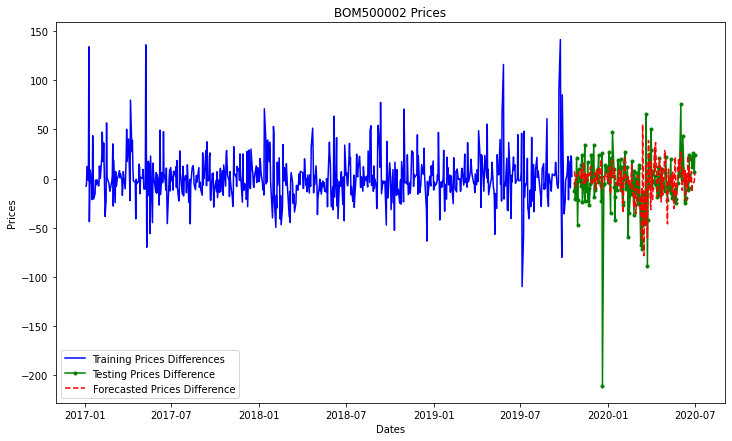

In [81]:
plt.figure(figsize=(12,7))
plt.title('BOM500002 Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(multi_train_data_diff[Y], color='blue', label='Training Prices Differences')
plt.plot(multi_test_data_diff[Y], color='green', marker='.', label='Testing Prices Difference')
plt.plot(predicted_test_data_diff['Predicted_'+Y], color='red', linestyle='--', label='Forecasted Prices Difference')
plt.legend();

In [82]:
multi_test_data_diff[Y]

Date
2019-10-22   -12.60
2019-10-23    -4.45
2019-10-24   -20.70
2019-10-25   -18.80
2019-10-27    20.95
              ...  
2020-06-24    11.45
2020-06-25    21.00
2020-06-26    26.10
2020-06-29     6.30
2020-06-30    23.70
Name: Close_BOM500002, Length: 172, dtype: float64

In [83]:
#reverse the foreasted values
reverse_multi_test_diff = np.r_[multi_test_data.iloc[0][Y], multi_test_data_diff[Y]].cumsum()
reverse_multi_predictions = np.r_[multi_test_data.iloc[0][Y], multi_predictions].cumsum()
reverse_multi_test_diff.shape, reverse_multi_predictions.shape


((173,), (173,))

In [84]:
error = mean_squared_error(reverse_multi_test_diff, reverse_multi_predictions)
print('Testing Mean Squared Error: %.3f' % error)

Testing Mean Squared Error: 212990.448


In [85]:
reverse_multi_test_diff_series = pd.Series(reverse_multi_test_diff)
reverse_multi_test_diff_series.index = multi_test_data.index

reverse_multi_predictions_series = pd.Series(reverse_multi_predictions)
reverse_multi_predictions_series.index = multi_test_data.index


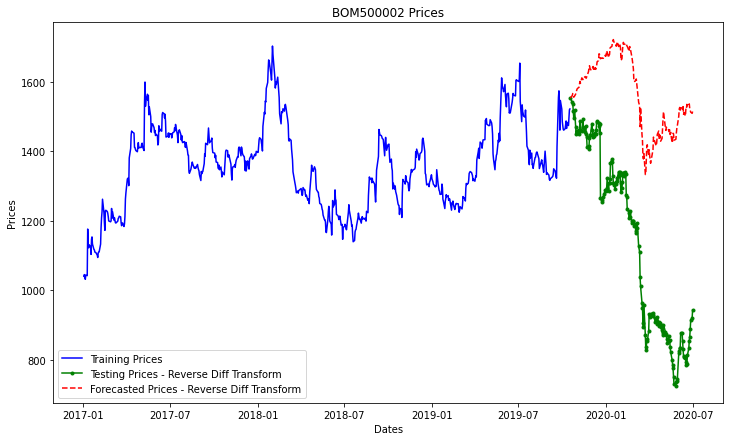

In [86]:
plt.figure(figsize=(12,7))
plt.title('BOM500002 Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_series, color='blue', label='Training Prices')
plt.plot(reverse_multi_test_diff_series, color='green', marker='.', label='Testing Prices - Reverse Diff Transform')
plt.plot(reverse_multi_predictions_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Diff Transform')
plt.legend();

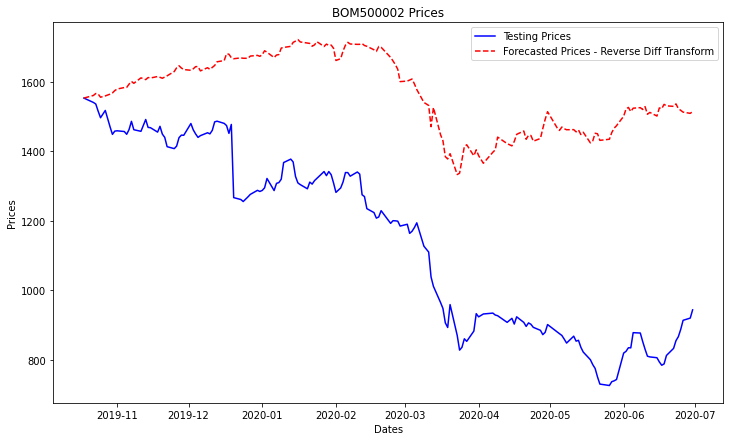

In [87]:
plt.figure(figsize=(12,7))
plt.title('BOM500002 Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(multi_test_data[Y], color='blue', label='Testing Prices')
#plt.plot(reverse_test_diff_series, color='green', marker='.', label='Testing Prices - Reverse Diff Transform')
plt.plot(reverse_multi_predictions_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Diff Transform')
plt.legend();